# CASE STUDY II: HEALTHCARE – EARLY DETECTION OF DIABETES
### TEAM GLUCOSE-GUARD DATA SCIENCE CAPSTONE PROJECT

## 1.0 INTRODUCTION

### 1.1 Background  
A mobile health clinic aims to pre-screen patients for diabetes using basic health indicators. This initiative seeks to reduce hospital crowding and allow healthcare providers to focus resources on individuals at higher risk of developing diabetes.

Using exploratory data analysis (EDA), this project uncovers the key factors that influence the risk of diabetes. Subsequently, classification models are developed to predict whether a person has diabetes based on clinical attributes such as body mass index (BMI), glucose levels, insulin levels, and age.

### 1.2 Objectives
1. Perform exploratory data analysis (EDA) to identify factors that greatly influence the risk of diabetes.

2. Develop classification models to predict if a person has diabetes based on health attributes like BMI, glucose levels, insulin levels, and age.

## 2.0 DATA PREPARATION

### 2.1 Importation of Libraries

In [71]:
# Import Libaries

## For data cleaning and descriptive statistics
import pandas as pd # for data manipulation
import numpy as np #for numerical operations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer # for advanced missing value imputation

## For EDA
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for advanced plotting
from scipy.stats import spearmanr, pearsonr # for correlation analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor # to detect multicollinearity
import statsmodels.api as sm # to add a constant term (intercept) to the feature matrix
sns.set(style='whitegrid') # Set seaborn style

## For inferential statistics
from scipy.stats import ttest_ind #for hypothesis testing across 2groups
from scipy.stats import f_oneway #for hypothesis testing across 3 or more groups
from scipy.stats import chi2_contingency #for testing for independence
import statsmodels.api as sm #used for anova table
from statsmodels.formula.api import ols #create a model and fitting

## For feature engineering and model building & evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import joblib

### 2.2 Loading of Dataset

In [72]:
# Loading dataset
df = pd.read_csv ("./diabetes.csv")

# Return first 5 rows
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [73]:
# Summary of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## 3.0 DATA CLEANING

### 3.1 Identifying columns where zeros are invalid

In [74]:
# Columns where 0 is likely a missing value
zero_as_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
print (f"These features should not be zero for real patients:{zero_as_missing}")

These features should not be zero for real patients:['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']


### 3.2 Creating Missingness Indicator Flags

In [75]:
# Adding missingness flags
for col in zero_as_missing:
    df[col + "_missing"] = df [col] == 0

In [76]:
# To verify that the flags are being correctly created
df[["Insulin", "Insulin_missing"]].head(10)

,Insulin,Insulin_missing
0,0,True
1,0,True
2,0,True
3,94,False
4,168,False
5,0,True
6,88,False
7,0,True
8,543,False
9,0,True


### 3.3 Replacing Zeros with NaN

In [77]:
# Replace 0s with NaN
df[zero_as_missing] = df[zero_as_missing].replace(0,np.nan)

In [78]:
# To confirm how many missing values exist in each column
print("This is the missing values existing in specified columns:")
df[zero_as_missing].isnull().sum()

This is the missing values existing in specified columns:


Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

### 3.4 Applying Iterative Imputer (Multivariate Imputation by Chained Equations [MICE])

Iterative Imputer fills in missing values by modeling each feature with missing values as a function of the other features. It's based on Multiple Imputation by Chained Equations (MICE).

So instead of guessing missing values with a mean or median, it:

1. Picks one feature with missing values.

2. Predicts those missing values using a regression model trained on the other columns.

3. Repeats this process for each feature with missing values, in a cycle, until the values stabilize.

This method preserves relationships between variables, which is critical in medical and clinical datasets.

In [79]:
# Separating target from features
X = df.drop(columns= "Outcome")
y = df["Outcome"]

In [80]:
# Applying Iterative Imputer
imputer = IterativeImputer(random_state=0)
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [81]:
# Ensuring all NaNs are gone and imputation worked
print(X_imputed.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Glucose_missing             0
BloodPressure_missing       0
SkinThickness_missing       0
Insulin_missing             0
BMI_missing                 0
dtype: int64


### 3.5 Comparison of Values Before and After

In [82]:
# Reprinting columns where 0 is likely a missing value
zero_as_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
print (f"These features should not be zero for real patients:{zero_as_missing}")

These features should not be zero for real patients:['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']


#### 3.5.1 Glucose Comparison

In [83]:
# Comparing values before and after for Glucose

# Get the describe() outputs
before_desc_glucose = df["Glucose"].describe()
after_desc_glucose = X_imputed["Glucose"].describe()

# Combine into a DataFrame
glucose_comparison = pd.DataFrame({
    "Metric": before_desc_glucose.index,
    "Before Imputation": before_desc_glucose.values,
    "After Imputation": after_desc_glucose.values
})

# Display as a table
glucose_comparison

,Metric,Before Imputation,After Imputation
0,count,763.000000,768.000000
1,mean,121.686763,121.641747
2,std,30.535641,30.466564
3,min,44.000000,44.000000
4,25%,99.000000,99.000000
5,50%,117.000000,117.000000
6,75%,141.000000,140.250000
7,max,199.000000,199.000000


#### 3.5.2 Blood Pressure Comparison

In [84]:
# Comparing values before and after for Blood Pressure

# Get the describe() outputs
before_desc_BloodPressure = df["BloodPressure"].describe()
after_desc_BloodPressure = X_imputed["BloodPressure"].describe()

# Combine into a DataFrame
BloodPressure_comparison = pd.DataFrame({
    "Metric": before_desc_BloodPressure.index,
    "Before Imputation": before_desc_BloodPressure.values,
    "After Imputation": after_desc_BloodPressure.values
})

# Display as a table
BloodPressure_comparison

,Metric,Before Imputation,After Imputation
0,count,733.000000,768.000000
1,mean,72.405184,72.361292
2,std,12.382158,12.147518
3,min,24.000000,24.000000
4,25%,64.000000,64.000000
5,50%,72.000000,72.000000
6,75%,80.000000,80.000000
7,max,122.000000,122.000000


#### 3.5.3 Skin Thickness

In [85]:
# Comparing values before and after for Skin Thickness

# Get the describe() outputs
before_desc_SkinThickness = df["SkinThickness"].describe()
after_desc_SkinThickness = X_imputed["SkinThickness"].describe()

# Combine into a DataFrame
SkinThickness_comparison = pd.DataFrame({
    "Metric": before_desc_SkinThickness.index,
    "Before Imputation": before_desc_SkinThickness.values,
    "After Imputation": after_desc_SkinThickness.values
})

# Display as a table
SkinThickness_comparison

,Metric,Before Imputation,After Imputation
0,count,541.000000,768.000000
1,mean,29.153420,28.926373
2,std,10.476982,9.521595
3,min,7.000000,7.000000
4,25%,22.000000,22.217409
5,50%,29.000000,28.442091
6,75%,36.000000,35.000000
7,max,99.000000,99.000000


#### 3.5.4 Insulin Comparison

In [86]:
# Comparing values before and after for Insulin

# Get the describe() outputs
before_desc_insulin = df["Insulin"].describe()
after_desc_insulin = X_imputed["Insulin"].describe()

# Combine into a DataFrame
insulin_comparison = pd.DataFrame({
    "Metric": before_desc_insulin.index,
    "Before Imputation": before_desc_insulin.values,
    "After Imputation": after_desc_insulin.values
})

# Display as a table
insulin_comparison

,Metric,Before Imputation,After Imputation
0,count,394.000000,768.000000
1,mean,155.548223,152.640510
2,std,118.775855,97.347662
3,min,14.000000,-19.487740
4,25%,76.250000,89.986466
5,50%,125.000000,130.196342
6,75%,190.000000,190.000000
7,max,846.000000,846.000000


All descriptive statistics are similar except **min** whose after imputation value is negative, which is not physiologically valid for Insulin.

To fix this, we will clip negative values to a realistic minimum

In [87]:
# Clipping insulin negative values to a realistic minimum of 14
X_imputed['Insulin'] = X_imputed['Insulin'].clip(lower=14)

##### 3.5.4.1 Updated Insulin Comparison

In [88]:
# Get updated describe() output
after_clipping_desc_insulin = X_imputed["Insulin"].describe()

# Re-create the comparison table
insulin_comparison_clipped = pd.DataFrame({
    "Metric": before_desc_insulin.index,
    "Before Imputation": before_desc_insulin.values,
    "After Imputation & Clipping": after_clipping_desc_insulin.values
})

# Display the new comparison table
insulin_comparison_clipped

,Metric,Before Imputation,After Imputation & Clipping
0,count,394.000000,768.000000
1,mean,155.548223,152.684350
2,std,118.775855,97.277600
3,min,14.000000,14.000000
4,25%,76.250000,89.986466
5,50%,125.000000,130.196342
6,75%,190.000000,190.000000
7,max,846.000000,846.000000


#### 3.5.5 Body Mass Index (BMI) Comparison

In [89]:
# Get the describe() outputs
before_desc_BMI = df["BMI"].describe()
after_desc_BMI = X_imputed["BMI"].describe()

# Combine into a DataFrame
BMI_comparison = pd.DataFrame({
    "Metric": before_desc_BMI.index,
    "Before Imputation": before_desc_BMI.values,
    "After Imputation": after_desc_BMI.values
})

# Display as a table
BMI_comparison

,Metric,Before Imputation,After Imputation
0,count,757.000000,768.000000
1,mean,32.457464,32.436839
2,std,6.924988,6.879242
3,min,18.200000,18.200000
4,25%,27.500000,27.500000
5,50%,32.300000,32.000000
6,75%,36.600000,36.600000
7,max,67.100000,67.100000


### 3.6 Combining Imputed Data with Target

In [90]:
# Combine Imputed Data with Target
df_imputed = X_imputed.copy()
df_imputed['Outcome'] = y.values # to ensure proper alignment

In [91]:
# Confirming combination
print("Target column added. Final DataFrame shape:", df_imputed.shape)
print("Column names:", df_imputed.columns.tolist())

Target column added. Final DataFrame shape: (768, 14)
Column names: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Glucose_missing', 'BloodPressure_missing', 'SkinThickness_missing', 'Insulin_missing', 'BMI_missing', 'Outcome']


In [92]:
# Ensuring final dataframe is assembled properly
print("Preview of final dataset:")
df_imputed.head()

Preview of final dataset:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Glucose_missing,BloodPressure_missing,SkinThickness_missing,Insulin_missing,BMI_missing,Outcome
0,6.0,148.0,72.0,35.000000,218.923435,33.6,0.627,50.0,0.0,0.0,0.0,1.0,0.0,1
1,1.0,85.0,66.0,29.000000,70.306082,26.6,0.351,31.0,0.0,0.0,0.0,1.0,0.0,0
2,8.0,183.0,64.0,21.640837,268.531745,23.3,0.672,32.0,0.0,0.0,1.0,1.0,0.0,1
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,137.0,40.0,35.000000,168.000000,43.1,2.288,33.0,0.0,0.0,0.0,0.0,0.0,1


### 3.7 Final Imputed Dataset

In [93]:
# Round imputed dataset to 2 decimal places
df_imputed = df_imputed.round(2)

In [94]:
# Save the imputed dataset
df_imputed.to_csv("diabetes_imputed.csv", index=False)
print("Dataset saved as 'diabetes_imputed.csv'")

Dataset saved as 'diabetes_imputed.csv'


This is the dataset we will be using for our EDA

## 4.0 DATA ANALYSIS

### 4.1 EXPLORATIVE DATA ANALYSIS (EDA)

#### 4.1.1 Inspection of Imputed dataset

In [95]:
# Display first 5 rows of dataset
df_imputed.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Glucose_missing,BloodPressure_missing,SkinThickness_missing,Insulin_missing,BMI_missing,Outcome
0,6.0,148.0,72.0,35.00,218.92,33.6,0.63,50.0,0.0,0.0,0.0,1.0,0.0,1
1,1.0,85.0,66.0,29.00,70.31,26.6,0.35,31.0,0.0,0.0,0.0,1.0,0.0,0
2,8.0,183.0,64.0,21.64,268.53,23.3,0.67,32.0,0.0,0.0,1.0,1.0,0.0,1
3,1.0,89.0,66.0,23.00,94.00,28.1,0.17,21.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,137.0,40.0,35.00,168.00,43.1,2.29,33.0,0.0,0.0,0.0,0.0,0.0,1


In [96]:
# Overview of data types and non-null counts
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Glucose_missing           768 non-null    float64
 9   BloodPressure_missing     768 non-null    float64
 10  SkinThickness_missing     768 non-null    float64
 11  Insulin_missing           768 non-null    float64
 12  BMI_missing               768 non-null    float64
 13  Outcome                   768 non-null    int64  
dtypes: float64

In [97]:
# Shape
print("Shape:", df_imputed.shape)

Shape: (768, 14)


#### 4.1.2 Class Distribution using Countplot
Is the dataset balanced?

Are there more diabetic or non-diabetic patients?

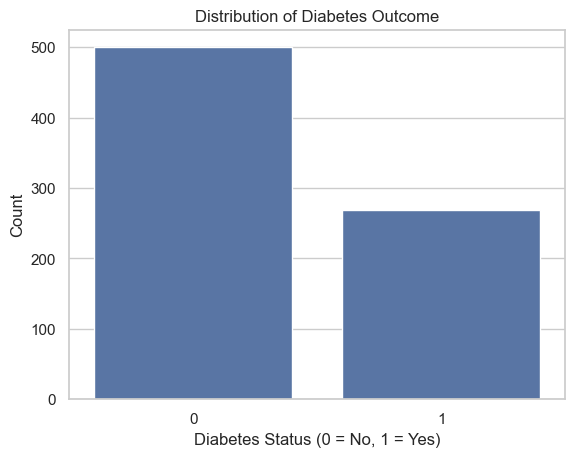

In [98]:
# Countplot
sns.countplot(x='Outcome', data=df_imputed)
plt.title("Distribution of Diabetes Outcome")
plt.xlabel("Diabetes Status (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

**Interpretation**

The dataset shows a **class imbalance** in the target variable (Outcome), with more individuals labeled as non-diabetic (Outcome = 0) compared to diabetic (Outcome = 1).

#### 4.1.3 Pregnancies and Diabetes Risk
Effect of number of pregnancies on diabetes outcome.

##### 4.1.3.1 Distribution Plot (Histogram) for Pregnancies

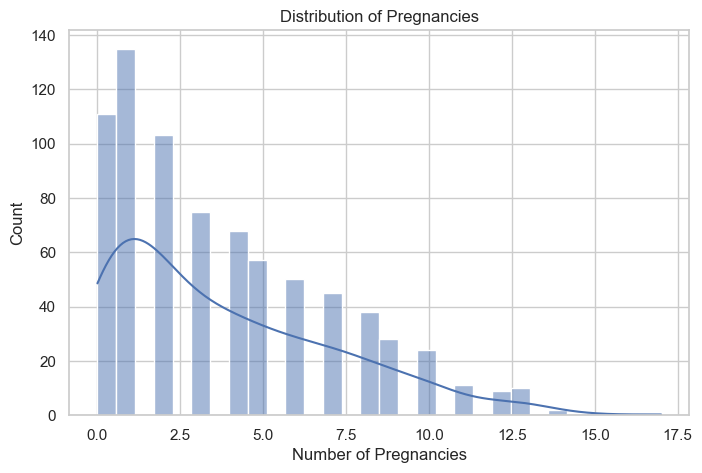

In [99]:
# Histogram
plt.figure(figsize=(8,5))
sns.histplot(df_imputed['Pregnancies'], kde=True, bins=30)
plt.title('Distribution of Pregnancies')
plt.xlabel('Number of Pregnancies')
plt.ylabel('Count')
plt.show()

##### 4.1.3.2 Group Comparison Box Plot (Pregnancies vs Outcome)

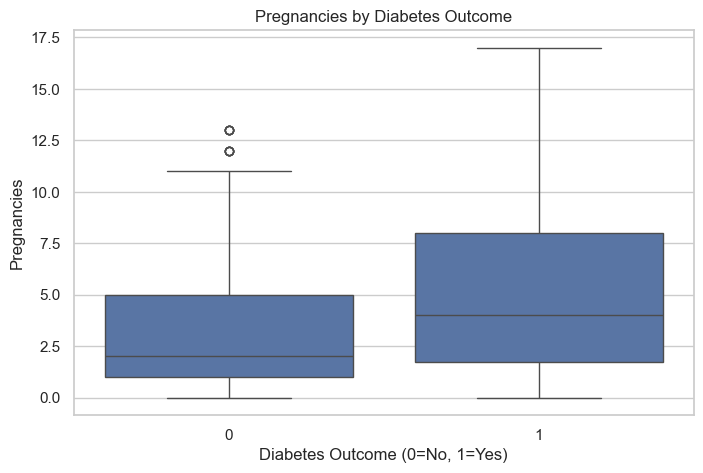

In [100]:
# Box Plot
plt.figure(figsize=(8,5))
sns.boxplot(x='Outcome', y='Pregnancies', data=df_imputed)
plt.title('Pregnancies by Diabetes Outcome')
plt.xlabel('Diabetes Outcome (0=No, 1=Yes)')
plt.ylabel('Pregnancies')
plt.show()

##### 4.1.3.3 Interpretation
Pregnancies show a right-skewed distribution with slightly higher counts among diabetics.

#### 4.1.4 Glucose Level Distribution and Impact
Glucose levels and their relationship with diabetes.

##### 4.1.4.1 Distribution Plot (Histogram) for Glucose Levels

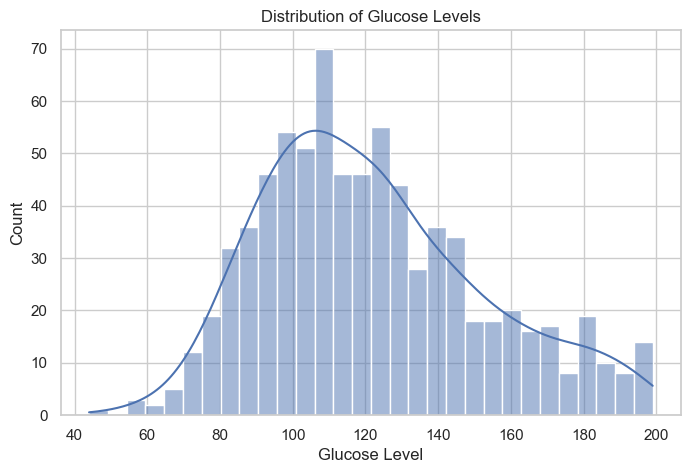

In [101]:
# Histogram
plt.figure(figsize=(8,5))
sns.histplot(df_imputed['Glucose'], kde=True, bins=30)
plt.title('Distribution of Glucose Levels')
plt.xlabel('Glucose Level')
plt.ylabel('Count')
plt.show()

##### 4.1.4.2 Group Comparison Box Plot (Glucose vs Outcome)

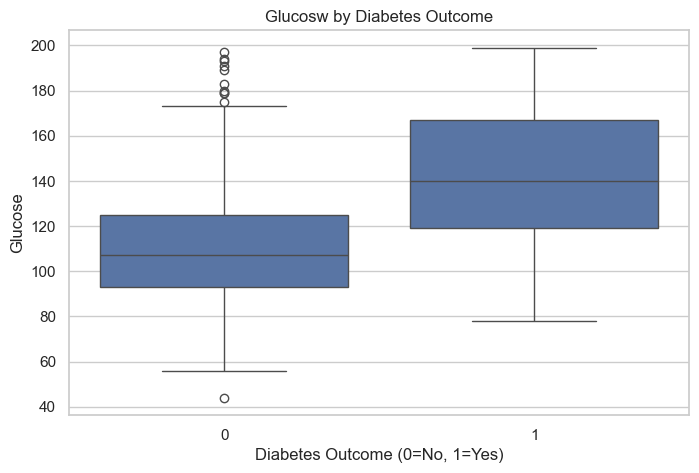

In [102]:
# Box Plot
plt.figure(figsize=(8,5))
sns.boxplot(x='Outcome', y='Glucose', data=df_imputed)
plt.title('Glucosw by Diabetes Outcome')
plt.xlabel('Diabetes Outcome (0=No, 1=Yes)')
plt.ylabel('Glucose')
plt.show()

##### 4.1.4.3 Interpretation
Glucose has visibly higher distributions among diabetic patients.

#### 4.1.5 Blood Pressure and Diabetes Association
Blood pressure patterns and relationship with diabetes.

##### 4.1.5.1 Distribution Plot (Histogram) for Blood Pressure

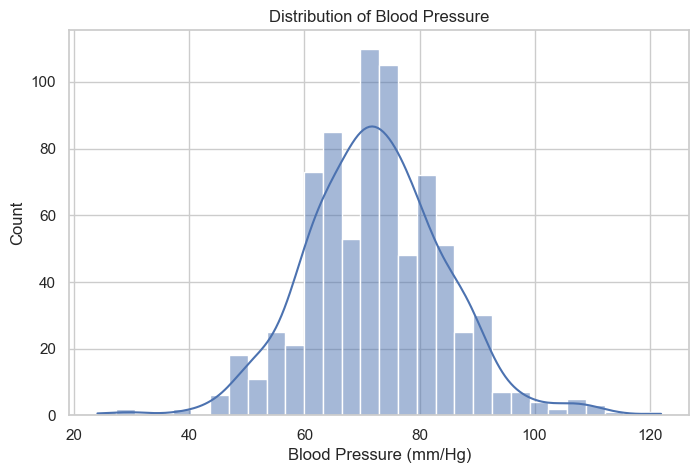

In [103]:
# Histogram
plt.figure(figsize=(8,5))
sns.histplot(df_imputed['BloodPressure'], kde=True, bins=30)
plt.title('Distribution of Blood Pressure')
plt.xlabel('Blood Pressure (mm/Hg)')
plt.ylabel('Count')
plt.show()

##### 4.1.5.2 Group Comparison Box Plot (Blood Pressure vs Outcome)

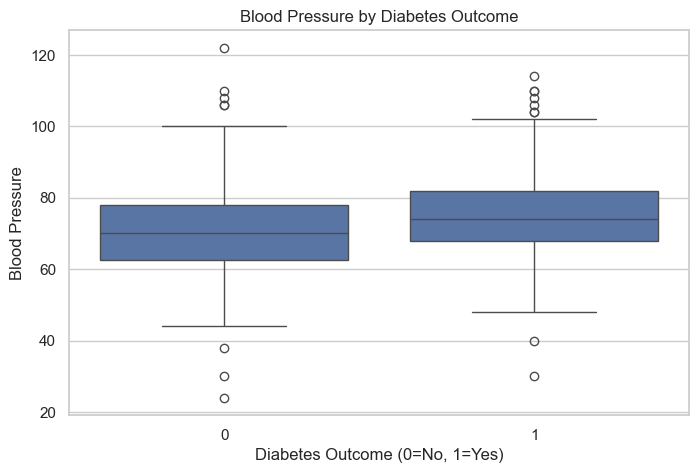

In [104]:
# Box Plot
plt.figure(figsize=(8,5))
sns.boxplot(x='Outcome', y='BloodPressure', data=df_imputed)
plt.title('Blood Pressure by Diabetes Outcome')
plt.xlabel('Diabetes Outcome (0=No, 1=Yes)')
plt.ylabel('Blood Pressure')
plt.show()

##### 4.1.5.3 Interpretation
Blood Pressure has overlapping distributions across classes, suggesting weaker predictive power.

#### 4.1.6 Skin Thickness and Diabetes
Skin thickness measurements in diabetic vs. non-diabetic groups.

##### 4.1.6.1 Distribution Plot (Histogram) for Skin Thickness

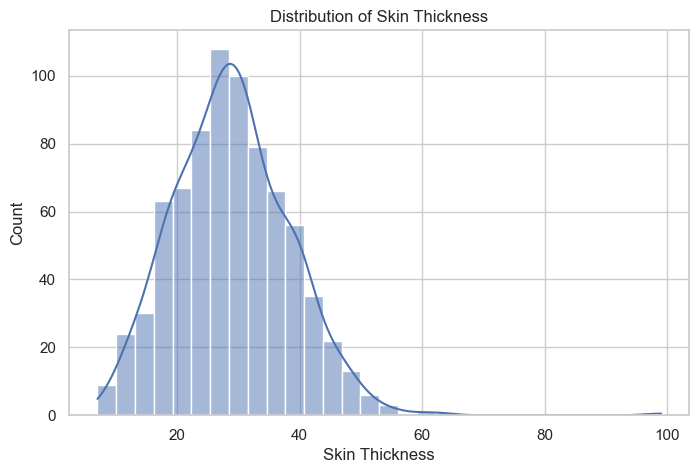

In [105]:
# Histogram
plt.figure(figsize=(8,5))
sns.histplot(df_imputed['SkinThickness'], kde=True, bins=30)
plt.title('Distribution of Skin Thickness')
plt.xlabel('Skin Thickness')
plt.ylabel('Count')
plt.show()

##### 4.1.6.2 Group Comparison Box Plot (Skin Thickness vs Outcome)

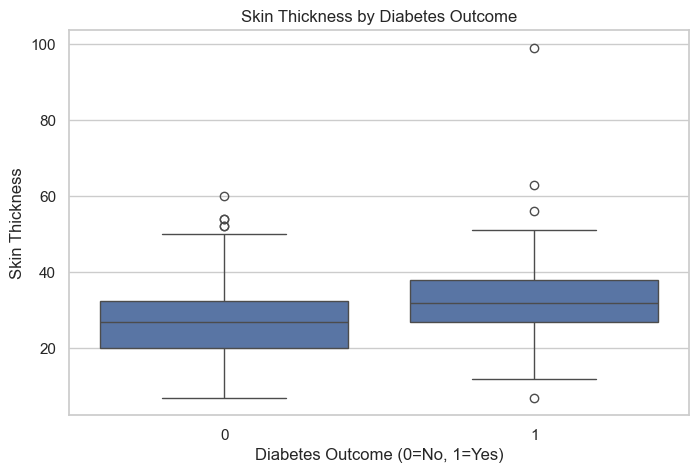

In [106]:
# Box Plot
plt.figure(figsize=(8,5))
sns.boxplot(x='Outcome', y='SkinThickness', data=df_imputed)
plt.title('Skin Thickness by Diabetes Outcome')
plt.xlabel('Diabetes Outcome (0=No, 1=Yes)')
plt.ylabel('Skin Thickness')
plt.show()

##### 4.1.6.3 Interpretation
Skin Thickness has overlapping distributions across classes, suggesting weaker predictive power.

#### 4.1.7 Insulin Levels and Impact on Diabetes

##### 4.1.7.1 Distribution Plot (Histogram) for Insulin Levels

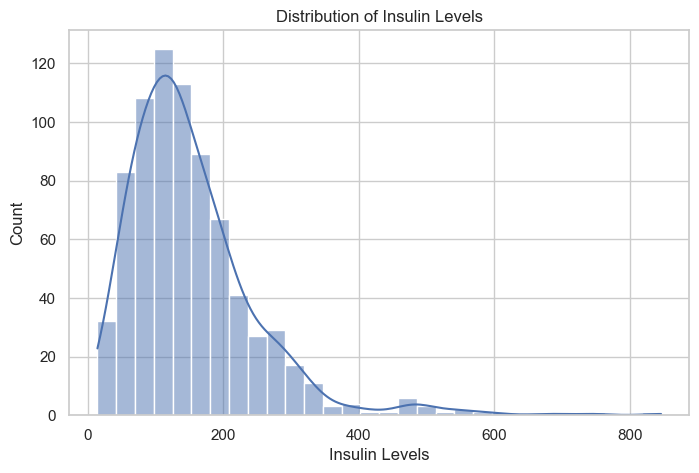

In [107]:
# Histogram
plt.figure(figsize=(8,5))
sns.histplot(df_imputed['Insulin'], kde=True, bins=30)
plt.title('Distribution of Insulin Levels')
plt.xlabel('Insulin Levels')
plt.ylabel('Count')
plt.show()

##### 4.1.7.2 Group Comparison Box Plot (Insulin vs Outcome)

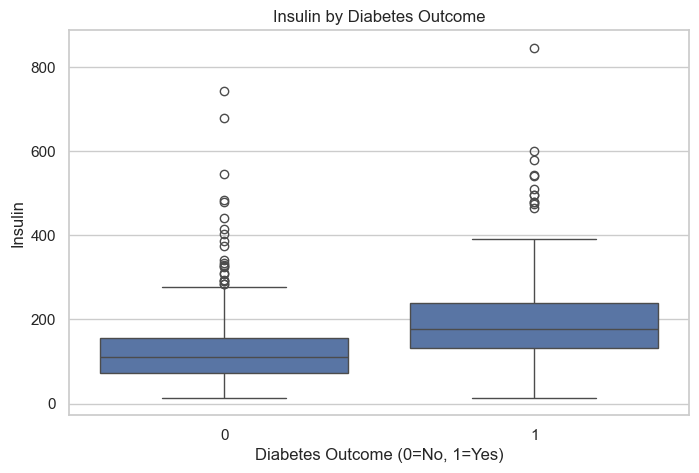

In [108]:
# Box Plot
plt.figure(figsize=(8,5))
sns.boxplot(x='Outcome', y='Insulin', data=df_imputed)
plt.title('Insulin by Diabetes Outcome')
plt.xlabel('Diabetes Outcome (0=No, 1=Yes)')
plt.ylabel('Insulin')
plt.show()

##### 4.1.7.3 Interpretation
Insulin shows a right-skewed distribution, suggesting that while most individuals have moderate insulin levels, a few have extremely high values. It also show shifts between diabetic and non-diabetic groups.

#### 4.1.8 Body Mass Index (BMI) and Diabetes
BMI’s influence on diabetes risk.

##### 4.1.8.1 Distribution Plot (Histogram) for BMI

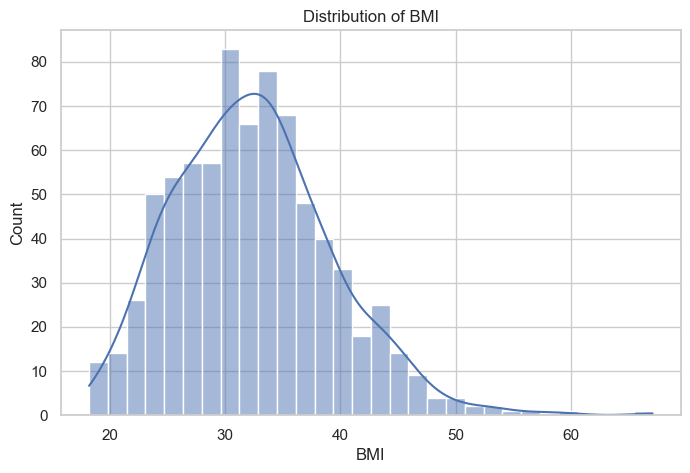

In [109]:
# Histogram
plt.figure(figsize=(8,5))
sns.histplot(df_imputed['BMI'], kde=True, bins=30)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

##### 4.1.8.2 Group Comparison Box Plot (BMI vs Outcome)

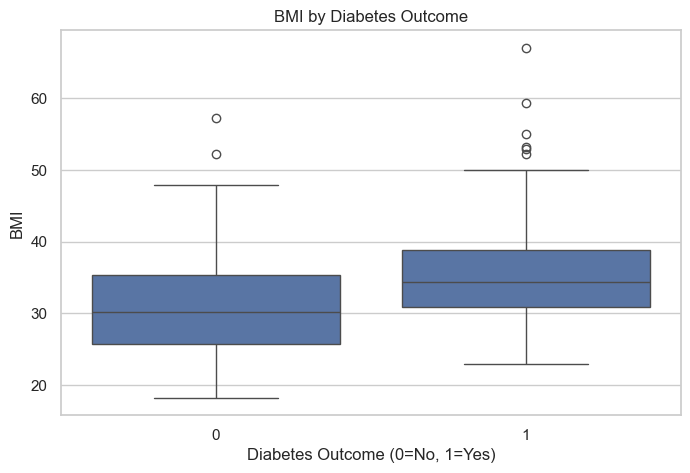

In [110]:
# Box Plot
plt.figure(figsize=(8,5))
sns.boxplot(x='Outcome', y='BMI', data=df_imputed)
plt.title('BMI by Diabetes Outcome')
plt.xlabel('Diabetes Outcome (0=No, 1=Yes)')
plt.ylabel('BMI')
plt.show()

##### 4.1.8.3 Interpretation
BMI has visibly higher distributions among diabetic patients.

#### 4.1.9 Diabetes Pedigree Function (Genetic Risk)
Genetic predisposition to diabetes through pedigree function.

##### 4.1.9.1 Distribution Plot (Histogram) for Diabetes Pedigree Function

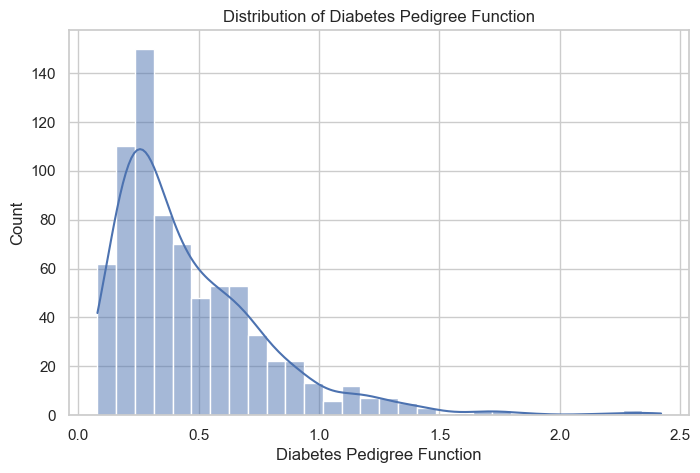

In [111]:
# Histogram
plt.figure(figsize=(8,5))
sns.histplot(df_imputed['DiabetesPedigreeFunction'], kde=True, bins=30)
plt.title('Distribution of Diabetes Pedigree Function')
plt.xlabel('Diabetes Pedigree Function')
plt.ylabel('Count')
plt.show()

##### 4.1.9.2 Group Comparison Box Plot (Diabetes Pedigree Function vs Outcome)

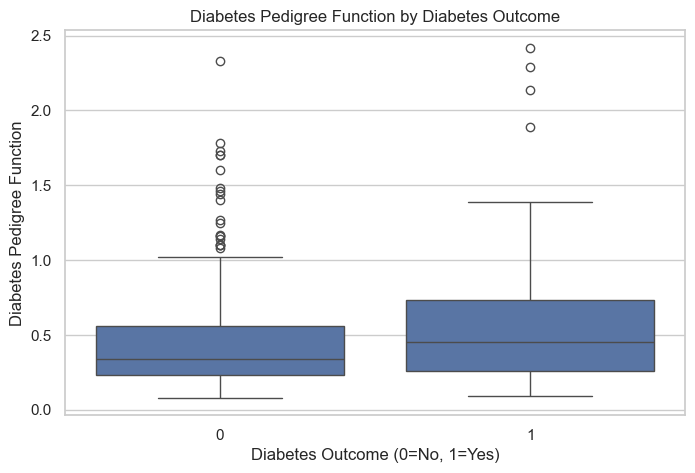

In [112]:
# Box Plot
plt.figure(figsize=(8,5))
sns.boxplot(x='Outcome', y='DiabetesPedigreeFunction', data=df_imputed)
plt.title('Diabetes Pedigree Function by Diabetes Outcome')
plt.xlabel('Diabetes Outcome (0=No, 1=Yes)')
plt.ylabel('Diabetes Pedigree Function')
plt.show()

##### 4.1.9.3 Interpretation
Diabetes Pedigree Function (DPF) shows shifts between diabetic and non-diabetic groups.

#### 4.1.10 Age Distribution and Diabetes Prevalence
Age-related trends in diabetes occurrence.

##### 4.1.10.1 Distribution Plot (Histogram) for Age

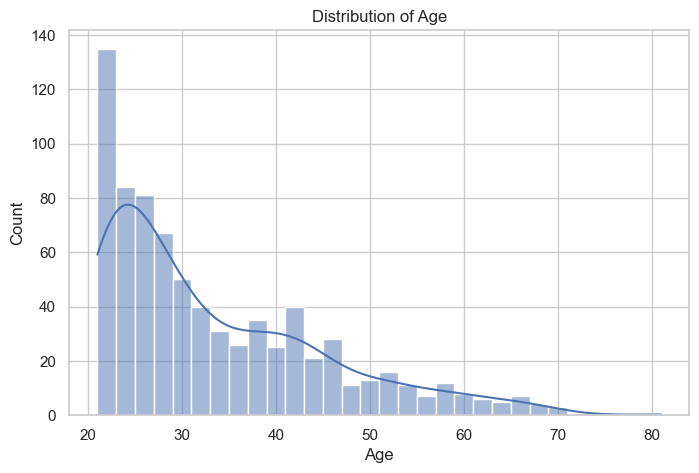

In [113]:
# Histogram
plt.figure(figsize=(8,5))
sns.histplot(df_imputed['Age'], kde=True, bins=30)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

##### 4.1.10.2 Group Comparison Box Plot (Age vs Outcome)

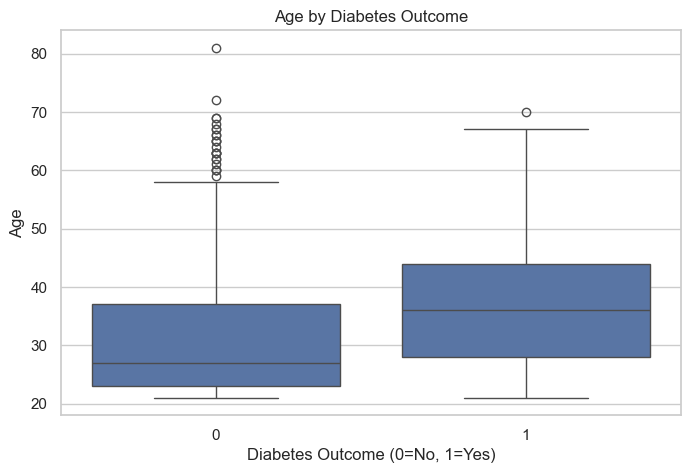

In [114]:
# Box Plot
plt.figure(figsize=(8,5))
sns.boxplot(x='Outcome', y='Age', data=df_imputed)
plt.title('Age by Diabetes Outcome')
plt.xlabel('Diabetes Outcome (0=No, 1=Yes)')
plt.ylabel('Age')
plt.show()

##### 4.1.10.3 Interpretation
Age shows shifts between diabetic and non-diabetic groups.

#### 4.1.11 Correlation Matrix and Multicollinearity Check

##### 4.1.11.1 Correlation Matrix demonstrated using Heatmap

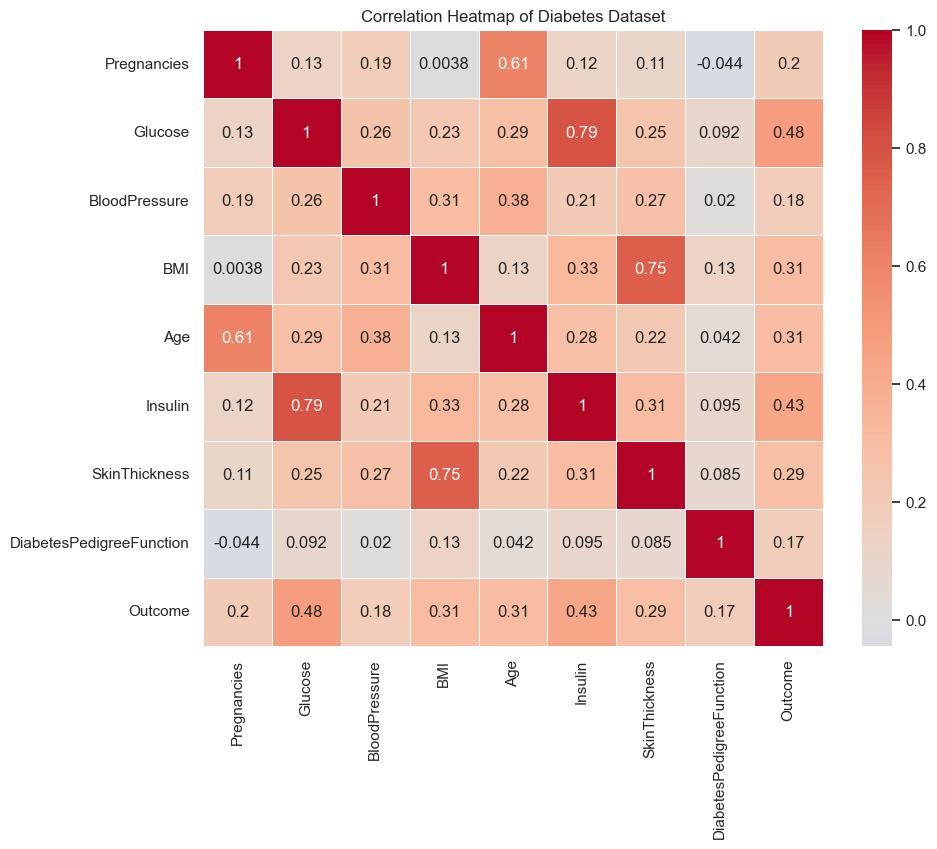

In [115]:
# Select numeric columns
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'Age',
           'Insulin', 'SkinThickness', 'DiabetesPedigreeFunction', 'Outcome']

# Compute Spearman correlation matrix
corr_matrix = df_imputed[columns].corr(method='spearman')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Heatmap of Diabetes Dataset')
plt.show()


**Intepretation**

The strongest positive correlation is between glucose and insulin levels.

Glucose has the strongest positive correlation with Outcome.

BMI and SkinThickness correlation indicate a strong positive linear relationship.

Pregnancies and Age correlation indicates a moderate to strong postive linear relationship.

DPF may show weak-to-moderate correlation but still contributes.

##### 4.1.11.2 Multicollinearity Check using Variance Inflation Factor (VIF)
VIF does quantitative measure of multicollinearity

In [116]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'Age', 'Insulin', 'SkinThickness', 'DiabetesPedigreeFunction']

X = df_imputed[features]
X_const = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(X.columns))]

vif_data

,feature,VIF
0,Pregnancies,1.435900
1,Glucose,2.070584
2,BloodPressure,1.269819
3,BMI,2.210755
4,Age,1.649578
5,Insulin,2.035444
6,SkinThickness,2.078679
7,DiabetesPedigreeFunction,1.045059


**Interpretation**

All VIF values are well below 5, which is commonly used as a threshold for concern.

This means multicollinearity is not a serious problem in this dataset.

All features can be safely kept in the classification model to be built without worrying about multicollinearity inflating variances.

#### 4.1.12 Key Findings from EDA

##### 1. Glucose
Patients with diabetes have **significantly higher glucose levels**, as shown by histograms and boxplots.
Glucose also shows one of the **strongest positive correlations with the Outcome variable**. Higher glucose levels are **strongly associated** with diabetic cases. It is a **key predictor of diabetes risk** and should be prioritized in model development.
##### 2. BMI (Body Mass Index)
Diabetic patients tend to have a **higher BMI distribution** compared to non-diabetics. Boxplots indicate a clear upward shift in BMI for the diabetic group. This supports the established medical link between **obesity and diabetes**. Higher BMI correlates with increased diabetes risk, as obesity is a **known contributor** to insulin resistance.
##### 3. Insulin
The insulin levels of diabetics are **more varied and generally higher**.
Some imputed values exist, but the trend remains visible.
Though slightly less correlated to the outcome variable than glucose or BMI, insulin still adds **predictive value**.
##### 4. Age
The average age of diabetic patients is higher, and age has a **moderate correlation** with the diabetes outcome.
This implies that **increasing age is associated with increased risk**. Older age groups show higher diabetes incidence, likely due to cumulative metabolic stress and declining insulin sensitivity.
##### 5. Diabetes Pedigree Function (DPF)
Diabetics exhibit **higher DPF values**.
While its correlation with Outcome is weaker than glucose or BMI, it still contributes to **risk profiling based on family history**, highlighting the role of heredity.
##### 6. Pregnancies
The variable is skewed, with a long tail, but still shows potential as a **contributing feature**, especially in this female-only dataset. Higher pregnancy counts correlate with increased diabetes risk, potentially due to gestational diabetes history or metabolic changes post-pregnancy.
##### 7. Skin Thickness & Blood Pressure
These features showed **less distinct separation** between diabetic and non-diabetic groups in boxplots.
They may carry **limited individual predictive power**, but could still add value in combination with stronger predictors.
**Higher skinfold thickness** (a proxy for body fat) correlates with **insulin resistance** and **diabetes risk**.
##### 8. Correlation of Insulin and Glucose
There is a **strong positive correlation** between glucose and insulin levels. Correlation heatmap shows that as glucose levels increase, insulin levels tend to increase as well. This relationship is expected, as insulin is the hormone responsible for lowering blood glucose, and higher glucose often triggers higher insulin production (unless insulin resistance or deficiency is present).
##### 9. Correlation between BMI and Skin Thickness
There is a **strong positive linear relationship** between BMI and skin thickness. This suggests that individuals with **higher BMI** tend to have **thicker skinfolds**, which aligns with the fact that both are **indicators of body fat**. Both BMI and SkinThickness are **biologically relevant** to **diabetes risk** (they relate to body fat and insulin resistance), so including them can improve model accuracy.
##### 10. Correlation between Pregnancies and Age
There is a **moderate to strong positive linear relationship** between age and the number of pregnancies. Older individuals tend to report more pregnancies, which is logically expected due to increased reproductive time. Both features are **logically linked to diabetes risk** — age is a major risk factor, and number of pregnancies (especially gestational diabetes) is also relevant.
##### 11. Multicollinearity (VIF Analysis)
All features had **VIF < 5**, indicating **no problematic multicollinearity**.
This means the features are not redundant and can be **safely included together** in the model.
##### 12. Outcome
There is **class imbalance**. The dataset is skewed: 500 non-diabetic (Class 0) vs. 268 diabetic (Class 1) cases. This imbalance may affect model accuracy if unaddressed.

### 4.2 DESCRIPTIVE STATISTICS

#### 4.2.1 Overall Descriptive Analysis

In [121]:
features = ["Pregnancies", "BloodPressure", "SkinThickness", 
            "Glucose", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

# Get the descriptive stats
combined_desc = df_imputed[features].describe().round(2).transpose()

# Display the table
print("\nOverall Descriptive Analysis:")
combined_desc


Overall Descriptive Analysis:


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.85,3.37,0.00,1.00,3.00,6.00,17.00
BloodPressure,768.0,72.36,12.15,24.00,64.00,72.00,80.00,122.00
SkinThickness,768.0,28.93,9.52,7.00,22.22,28.44,35.00,99.00
Glucose,768.0,121.64,30.47,44.00,99.00,117.00,140.25,199.00
Insulin,768.0,152.68,97.28,14.00,89.99,130.20,190.00,846.00
BMI,768.0,32.44,6.88,18.20,27.50,32.00,36.60,67.10
DiabetesPedigreeFunction,768.0,0.47,0.33,0.08,0.24,0.37,0.63,2.42
Age,768.0,33.24,11.76,21.00,24.00,29.00,41.00,81.00


#### 4.2.2 Descriptive Analysis based on Diabetic Status

In [127]:
# Step 1: Define the features to analyze
features = ["Pregnancies", "BloodPressure", "SkinThickness", 
            "Glucose", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

# Step 2: Compute grouped descriptive statistics by Outcome
grouped_desc = df_imputed.groupby("Outcome")[features].describe().round(2)

# Step 3: For Non-Diabetics (Outcome = 0)
non_diabetic_desc = grouped_desc.loc[0].T.reset_index()
non_diabetic_desc.columns = ['Feature', 'Statistic', 'Value']
non_diabetic_table = non_diabetic_desc.pivot(index='Feature', columns='Statistic', values='Value').reset_index()
non_diabetic_table = non_diabetic_table.round(2)

# Step 4: For Diabetics (Outcome = 1)
diabetic_desc = grouped_desc.loc[1].T.reset_index()
diabetic_desc.columns = ['Feature', 'Statistic', 'Value']
diabetic_table = diabetic_desc.pivot(index='Feature', columns='Statistic', values='Value').reset_index()
diabetic_table = diabetic_table.round(2)

# Step 5: Print both tables
print("Descriptive Statistics for Non-Diabetics:")
non_diabetic_table

print("\nDescriptive Statistics for Diabetics:")
diabetic_table

Descriptive Statistics for Non-Diabetics:

Descriptive Statistics for Diabetics:


Statistic,Feature,25%,50%,75%,count,max,mean,min,std
0,Age,28.00,36.00,44.00,268.0,70.00,37.07,21.00,10.97
1,BMI,30.90,34.30,38.78,268.0,67.10,35.39,22.90,6.59
2,BloodPressure,68.00,74.00,82.00,268.0,114.00,75.27,30.00,11.98
3,DiabetesPedigreeFunction,0.26,0.45,0.73,268.0,2.42,0.55,0.09,0.37
4,Glucose,119.00,140.00,167.00,268.0,199.00,142.24,78.00,29.50
5,Insulin,130.98,178.11,240.16,268.0,846.00,200.49,14.00,103.19
6,Pregnancies,1.75,4.00,8.00,268.0,17.00,4.87,0.00,3.74
7,SkinThickness,27.00,32.00,37.95,268.0,99.00,32.55,7.00,9.17


#### 4.2.3 Save Descriptive Statistics into Excel Workbook

In [128]:
with pd.ExcelWriter("diabetes_descriptive_stats.xlsx") as writer:
    combined_desc.to_excel(writer, sheet_name="Overall Descriptive Analysis", index=False)
    non_diabetic_table.to_excel(writer, sheet_name="Non-Diabetics", index=False)
    diabetic_table.to_excel(writer, sheet_name="Diabetics", index=False)

print("Dataset saved as 'diabetes_descriptive_stats.xlsx'")

ModuleNotFoundError: No module named 'openpyxl'

#### 4.2.4 Key Findings from Descriptive Statistics

##### 1. Glucose Levels
Diabetic patients have a **significantly higher mean glucose** (approx. 141 mg/dL) than non-diabetics (approx. 110 mg/dL).
This confirms that **glucose is a strong predictor** of diabetes.
##### 2. Insulin Levels
Though there are missing/imputed values, the **mean insulin** level is higher in diabetics.
There's also **greater variance** in insulin values among diabetics, suggesting that abnormal insulin response is a factor.
##### 3. BMI (Body Mass Index)
Diabetics tend to have **higher average BMI** than non-diabetics.
This supports the known link between obesity and diabetes risk.
##### 4. Age
The average age of diabetics is **significantly higher** than non-diabetics.
This indicates increasing age is associated with greater diabetes risk.
##### 5. Diabetes Pedigree Function (DPF)
Diabetics show a **higher average DPF**, suggesting **family history is also a contributing factor**.
##### 6. Other Features (like Pregnancies, Blood Pressure, Skin Thickness)
Some differences exist but are **less distinct** than glucose or BMI.
They may contribute moderately to prediction but likely **less influential individually**.

### 4.3 INFERENTIAL STATISTICS

#### 4.3.1 Grouping Pregnancy and Age columns

In [129]:
# Group Age into categories
def age_group(age):
    if age < 30:
        return "Young"
    elif 30 <= age <= 50:
        return "Middle-aged"
    else:
        return "Old"
df_imputed['AgeGroup'] = df_imputed['Age'].apply(age_group)

# Group Pregnancies into categories
def pregnancy_group(preg):
    if preg == 0:
        return "None"
    elif preg == 1:
        return "Low"
    elif 2<= preg <= 4:
        return "Medium"
    else:
        return "High"

df_imputed['PregnancyGroup'] = df_imputed['Pregnancies'].apply(pregnancy_group)

df_imputed[['Pregnancies', 'PregnancyGroup', 'Age', 'AgeGroup']].head()

,Pregnancies,PregnancyGroup,Age,AgeGroup
0,6.0,High,50.0,Middle-aged
1,1.0,Low,31.0,Middle-aged
2,8.0,High,32.0,Middle-aged
3,1.0,Low,21.0,Young
4,0.0,None,33.0,Middle-aged


#### 4.3.2 Hypothesis Testing

##### 4.3.2.1 Mean Glucose (Diabetic vs Non-Diabetic)

The goal is to compare the glucose mean across the 2 groups (diabetic and non-diabetic) and see if there's a difference

null hypothesis: There is no significant difference in the glucose mean across the 2 groups.

alternative hypothesis: There is a significant difference in the glucose mean across the 2 groups

Decision rule: Reject null hypothesis if p-value is lesser than the significant level.

In [130]:
#At 95% level of significance
glucose1 = df_imputed[df_imputed['Outcome'] == 1]['Glucose']
glucose2 = df_imputed[df_imputed['Outcome'] == 0]['Glucose']

#Using t-test because it's between 2 groups
t_stat_glucose, p_val_glucose = ttest_ind(glucose1, glucose2)
print(f"The T-test result for glucose includes: t-statistic= {t_stat_glucose} and the p-value= {p_val_glucose}.")

if p_val_glucose < 0.05: #level of significance
    print("Reject the null hypothesis. \nThere is a significant difference in the glucose mean across the 2 groups")
else:
    print("Fail to reject the null hypothesis. \nThere is no significant difference in the glucose mean across the 2 groups")

The T-test result for glucose includes: t-statistic= 15.7753453996013 and the p-value= 9.311170769268823e-49.
Reject the null hypothesis. 
There is a significant difference in the glucose mean across the 2 groups


##### 4.3.2.2 Mean Insulin (Diabetic vs Non-Diabetic)


The goal is to compare the insulin mean across the 2 groups (diabetic and non-diabetic) and see if there's a difference

null hypothesis: There is no significant difference in the insulin mean across the 2 groups.

alternative hypothesis: There is a significant difference in the insulin mean across the 2 groups

Decision rule: Reject null hypothesis if p-value is lesser than the significant level.

In [131]:
#At 95% level of significance
insulin1 = df_imputed[df_imputed['Outcome'] == 1]['Insulin']
insulin2 = df_imputed[df_imputed['Outcome'] == 0]['Insulin']

#Using t-test because it's between 2 groups
t_stat_insulin, p_val_insulin = ttest_ind(insulin1, insulin2)
print(f"The T-test result for insulin includes: t-statistic= {t_stat_insulin} and the p-value= {p_val_insulin}.")

if p_val_insulin < 0.05: #level of significance
    print("Reject the null hypothesis. \nThere is a significant difference in the insulin mean across the 2 groups")
else:
    print("Fail to reject the null hypothesis. \nThere is no significant difference in the insulin mean across the 2 groups")

The T-test result for insulin includes: t-statistic= 10.680239235848315 and the p-value= 6.451165748791912e-25.
Reject the null hypothesis. 
There is a significant difference in the insulin mean across the 2 groups


##### 4.3.2.3 Mean BloodPressure (Diabetic vs Non-Diabetic)

The goal is to compare the bloodpressure mean across the 2 groups (diabetic and non-diabetic) and see if there's a difference

null hypothesis: There is no significant difference in the bloodpressure mean across the 2 groups.

alternative hypothesis: There is a significant difference in the bloodpressure mean across the 2 groups

Decision rule: Reject null hypothesis if p-value is lesser than the significant level.

In [132]:
#At 95% level of significance
bp1 = df_imputed[df_imputed['Outcome'] == 1]['BloodPressure']
bp2 = df_imputed[df_imputed['Outcome'] == 0]['BloodPressure']

#Using t-test because it's between 2 groups
t_stat_bp, p_val_bp = ttest_ind(bp1, bp2)
print(f"The T-test result for bloodpressure includes: t-statistic= {t_stat_bp} and the p-value= {p_val_bp}.")

if p_val_bp < 0.05: #level of significance
    print("Reject the null hypothesis. \nThere is a significant difference in the bloodpressure mean across the 2 groups")
else:
    print("Fail to reject the null hypothesis. \nThere is no significant difference in the bloodpressure mean across the 2 groups")

The T-test result for bloodpressure includes: t-statistic= 4.924388666257176 and the p-value= 1.0370248194518666e-06.
Reject the null hypothesis. 
There is a significant difference in the bloodpressure mean across the 2 groups


##### 4.3.2.4 Mean DiabetesPedigreeFunction (Diabetic vs Non-Diabetic)

The goal is to compare the DiabetesPedigreeFunction mean across the 2 groups (diabetic and non-diabetic) and see if there's a difference

null hypothesis: There is no significant difference in the DiabetesPedigreeFunction mean across the 2 groups.

alternative hypothesis: There is a significant difference in the DiabetesPedigreeFunction mean across the 2 groups

Decision rule: Reject null hypothesis if p-value is lesser than the significant level.

In [133]:
#At 95% level of significance
DPF1 = df_imputed[df_imputed['Outcome'] == 1]['DiabetesPedigreeFunction']
DPF2 = df_imputed[df_imputed['Outcome'] == 0]['DiabetesPedigreeFunction']

#Using t-test because it's between 2 groups
t_stat_DPF, p_val_DPF = ttest_ind(DPF1, DPF2)
print(f"The T-test result for DiabetesPedigreeFunction includes: t-statistic= {t_stat_DPF} and the p-value= {p_val_DPF}.")

if p_val_DPF < 0.05: #level of significance
    print("Reject the null hypothesis. \nThere is a significant difference in the DiabetesPedigreeFunction mean across the 2 groups")
else:
    print("Fail to reject the null hypothesis. \nThere is no significant difference in the DiabetesPedigreeFunction mean across the 2 groups")

The T-test result for DiabetesPedigreeFunction includes: t-statistic= 4.8697072359831095 and the p-value= 1.3580536117813747e-06.
Reject the null hypothesis. 
There is a significant difference in the DiabetesPedigreeFunction mean across the 2 groups


##### 4.3.2.5 Mean BMI across age groups

The goal is to see if the BMI mean across the different age groups(Youth-Old) differ.

null hypothesis: BMI mean is equal across age groups

alternative hypothesis: At least one age group has a BMI mean different from the others.

Decision rule: Reject null hypothesis if p-value is lesser than the significant level.

In [134]:
#At 95% significant level
BMI_young = df_imputed[df_imputed['AgeGroup'] == 'Young']['BMI']
BMI_middle_aged = df_imputed[df_imputed['AgeGroup'] == 'Middle-aged']['BMI']
BMI_old = df_imputed[df_imputed['AgeGroup'] == 'Old']['BMI']

#Using ANOVA because the groups are more than 2
f_stat_BMI, p_val_BMI = f_oneway(BMI_young, BMI_middle_aged, BMI_old)
print(f"ANOVA result for BMI: F-statistic= {f_stat_BMI} and p-value= {p_val_BMI}")

if p_val_BMI < 0.05: #level of significance
    print("Reject the null hypothesis. \nAt least one age group BMI mean differs from the others")
else:
    print("Fail to reject the null hypothesis. \nBMI mean is not equal across the age groups")

ANOVA result for BMI: F-statistic= 5.497811874361184 and p-value= 0.004259193665760479
Reject the null hypothesis. 
At least one age group BMI mean differs from the others


##### 4.3.2.6 Mean BloodPressure across age groups

The goal is to see if the mean bloodpressure across the different age groups(Youth-Old) are differ.

null hypothesis: Bloodpressure mean is equal across age groups

alternative hypothesis: At least one age group has a BloodPressure mean different from the others.

Decision rule: Reject null hypothesis if p-value is lesser than the significant level.

In [135]:
#At 95% significant level
bp_young = df_imputed[df_imputed['AgeGroup'] == 'Young']['BloodPressure']
bp_middle_aged = df_imputed[df_imputed['AgeGroup'] == 'Middle-aged']['BloodPressure']
bp_old = df_imputed[df_imputed['AgeGroup'] == 'Old']['BloodPressure']

#Using ANOVA because the groups are more than 2
f_stat_BP, p_val_BP = f_oneway(bp_young, bp_middle_aged, bp_old)
print(f"ANOVA result for BloodPressure: F-statistic= {f_stat_BP} and p-value= {p_val_BP}")

if p_val_BP < 0.05: #level of significance
    print("Reject the null hypothesis. \nAt least one age group BloodPressure mean differs from the others")
else:
    print("Fail to reject the null hypothesis. \nBloodPressure mean is not equal across the age groups")

ANOVA result for BloodPressure: F-statistic= 42.583462404422214 and p-value= 2.9183711799708068e-18
Reject the null hypothesis. 
At least one age group BloodPressure mean differs from the others


##### 4.3.2.7 Mean SkinThickness across pregnancy groups

The goal is to see if the mean skinthickness across the different pregnancy groups(none-high) are equal.

null hypothesis: Skinthickness mean is equal across pregnancy groups

alternative hypothesis: At least one pregnancy group has a SkinThickness mean different from the others.

Decision rule: Reject null hypothesis if p-value is lesser than the significant level.

In [136]:
#At 95% significant level
skinthickness_none = df_imputed[df_imputed['PregnancyGroup'] == 'None']['SkinThickness']
skinthickness_low = df_imputed[df_imputed['PregnancyGroup'] == 'Low']['SkinThickness']
skinthickness_medium = df_imputed[df_imputed['PregnancyGroup'] == 'Medium']['SkinThickness']
skinthickness_high = df_imputed[df_imputed['PregnancyGroup'] == 'High']['SkinThickness']

#Using ANOVA because the groups are more than 2
f_stat_skinThi, p_val_skinThi = f_oneway(skinthickness_none, skinthickness_low, skinthickness_medium, skinthickness_high)
print(f"ANOVA result for SkinThickness: F-statistic= {f_stat_skinThi} and p-value= {p_val_skinThi}")

if p_val_skinThi < 0.05: #level of significance
    print("Reject the null hypothesis. \nAt least one pregnancy group SkinThickness mean differs from the others")
else:
    print("Fail to reject the null hypothesis. \nSkinThickness mean is not equal across the pregnancy groups")

ANOVA result for SkinThickness: F-statistic= 8.269489406245441 and p-value= 2.0312583168446416e-05
Reject the null hypothesis. 
At least one pregnancy group SkinThickness mean differs from the others


##### 4.3.2.8 Mean Glucose across pregnancy groups

The goal is to see if the mean glucose across the different pregnancy groups(none-high) are equal.

null hypothesis: Glucose mean is equal across pregnancy groups

alternative hypothesis: At least one pregnancy group has a Glucose mean different from the others.

Decision rule: Reject null hypothesis if p-value is lesser than the significant level.

In [137]:
#At 95% significant level
glucose_none = df_imputed[df_imputed['PregnancyGroup'] == 'None']['Glucose']
glucose_low = df_imputed[df_imputed['PregnancyGroup'] == 'Low']['Glucose']
glucose_medium = df_imputed[df_imputed['PregnancyGroup'] == 'Medium']['Glucose']
glucose_high = df_imputed[df_imputed['PregnancyGroup'] == 'High']['Glucose']

#Using ANOVA because the groups are more than 2
f_stat_gluc, p_val_gluc = f_oneway(glucose_none, glucose_low, glucose_medium, glucose_high)
print(f"ANOVA result for Glucose: F-statistic= {f_stat_gluc} and p-value= {p_val_gluc}")

if p_val_gluc < 0.05: #level of significance
    print("Reject the null hypothesis. \nAt least one pregnancy group Glucose mean differs from the others")
else:
    print("Fail to reject the null hypothesis. \nGlucose mean is not equal across the pregnancy groups")

ANOVA result for Glucose: F-statistic= 5.897417839872992 and p-value= 0.0005571319906963779
Reject the null hypothesis. 
At least one pregnancy group Glucose mean differs from the others


##### 4.3.2.9 Mean BloodPressure across pregnancy groups

The goal is to see if the mean bloodpressure across the different pregnancy groups(none-high) are equal.

null hypothesis: BloodPressure mean is equal across pregnancy groups

alternative hypothesis: At least one pregnancy group has a BloodPressure mean different from the others.

Decision rule: Reject null hypothesis if p-value is lesser than the significant level.

In [138]:
#At 95% significant level
BP_none = df_imputed[df_imputed['PregnancyGroup'] == 'None']['BloodPressure']
BP_low = df_imputed[df_imputed['PregnancyGroup'] == 'Low']['BloodPressure']
BP_medium = df_imputed[df_imputed['PregnancyGroup'] == 'Medium']['BloodPressure']
BP_high = df_imputed[df_imputed['PregnancyGroup'] == 'High']['BloodPressure']

#Using ANOVA because the groups are more than 2
f_stat_bloodP, p_val_bloodP = f_oneway(BP_none, BP_low, BP_medium, BP_high)
print(f"ANOVA result for BloodPressure: F-statistic= {f_stat_bloodP} and p-value= {p_val_bloodP}")

if p_val_gluc < 0.05: #level of significance
    print("Reject the null hypothesis. \nAt least one pregnancy group BloodPressure mean differs from the others")
else:
    print("Fail to reject the null hypothesis. \nBloodPressure mean is not equal across the pregnancy groups")

ANOVA result for BloodPressure: F-statistic= 18.57829091214917 and p-value= 1.219362867332646e-11
Reject the null hypothesis. 
At least one pregnancy group BloodPressure mean differs from the others


#### 4.3.3 Test of Independence

##### 4.3.3.1 AgeGroup and Outcome

The goal is to test if the 2 categorical variables are independent.

null hypothesis: AgeGroup and Outcome are independent

alternative hypothesis: AgeGroup and Outcome are dependent

Decision rule: Reject null hypothesis if p-value is lesser than the significant level.

In [139]:
# Cross-tab for AgeGroup vs Outcome
contingency_ageGroup = pd.crosstab(df_imputed['AgeGroup'], df_imputed['Outcome'])

#At 95% level of confidence
chi2_age, p_age, dof_age, expected_age = chi2_contingency(contingency_ageGroup)
print("Chi-square test result:", chi2_age, p_age)

if p_age < 0.05: #level of significance
    print("Reject the null hypothesis. \nAgeGroup and Outcome are dependent")
else:
    print("Fail to reject the null hypothesis. \nAgeGroup and Outcome are independent")

Chi-square test result: 67.67732168274529 2.0139854171655205e-15
Reject the null hypothesis. 
AgeGroup and Outcome are dependent


##### 4.3.3.2 PregnancyGroup and Outcome

The goal is to test if the 2 categorical variables are independent.

null hypothesis: PregnancyGroup and Outcome are independent

alternative hypothesis: PregnancyGroup and Outcome are dependent

Decision rule: Reject null hypothesis if p-value is lesser than the significant level.

In [140]:
# Cross-tab for PregnancyGroup vs Outcome
contingency_pregnancyGroup = pd.crosstab(df_imputed['PregnancyGroup'], df_imputed['Outcome'])

#At 95% level of confidence
chi2_pregnancy, p_pregnancy, dof_pregnancy, expected_pregnancy = chi2_contingency(contingency_ageGroup)
print("Chi-square test result:", chi2_pregnancy, p_pregnancy)

if p_pregnancy < 0.05: #level of significance
    print("Reject the null hypothesis. \nPregnancyGroup and Outcome are dependent")
else:
    print("Fail to reject the null hypothesis. \nPregnancyGroup and Outcome are independent")

Chi-square test result: 67.67732168274529 2.0139854171655205e-15
Reject the null hypothesis. 
PregnancyGroup and Outcome are dependent


#### 4.3.4 Key Findings from Inferential Statistics

##### 1. Mean Glucose (Diabetic vs Non-Diabetic)
We rejected the null hypothesis, concluding that there's a significant difference in the glucose mean across the 2 groups. Therefore, diabetics tend to have higher glucose levels than non-diabetics — a strong indicator that Glucose is a key predictor of diabetes.

##### 2. Mean Insulin (Diabetic vs Non-Diabetic)
We rejected the null hypothesis, concluding that there's a significant difference in the insulin mean across the 2 groups. Therefore, Insulin levels differ significantly between diabetic and non-diabetic individuals, suggesting insulin could help the model distinguish outcomes.

##### 3. Mean Blood Pressure (Diabetic vs Non-Diabetic)
We rejected the null hypothesis, concluding that there's a significant difference in the blood pressure mean across the 2 groups. Therefore, BloodPressure may contribute modestly to diabetes classification.

##### 4. Mean Diabetes Pedigree Function (Diabetic vs Non-Diabetic)
We rejected the null hypothesis, concluding that there's a significant difference in the diabetes pedigree function mean across the 2 groups, Therefore, Family history (DPF) is statistically associated with diabetes status.

##### 5. Mean BMI across Age Groups
We rejected the null hypothesis, concluding that at least one age group has a BMI mean different from the others. BMI changes across age groups and might suggest that age moderates the effect of BMI on diabetes. It could be useful for model interactions.

##### 6. Mean Blood Pressure across Age Groups
We rejected the null hypothesis, concluding that at least one age group has a BloodPressure mean different from the others. If BP increases with age, this reflects real-world health patterns and supports age as a strong contextual variable.

##### 7. Mean SkinThickness across Pregnancy Groups
We rejected the null hypothesis, concluding that at least one pregnancy group has a SkinThickness mean different from the others. It may be worth including as a feature in age-adjusted or pregnancy-adjusted models. This suggests that metabolic changes associated with pregnancy count may influence subcutaneous fat storage, reflected in skin thickness measurements. While skin thickness may not be a direct predictor of diabetes on its own, it could serve as a supporting feature in models when combined with variables like BMI, insulin, or pregnancy count.

##### 8. Mean Glucose across Pregnancy Groups
We rejected the null hypothesis, concluding that at least one pregnancy group has a glucose mean different from the others. Glucose increases with pregnancy, this supports the idea that higher pregnancies may correlate with higher glucose/diabetes risk.

##### 9. Mean BloodPressure across Pregnancy Groups
We rejected the null hypothesis, concluding that at least one pregnancy group has a bloodpressure mean different from the others. The difference was statistically significant, this suggests that pregnancy count may influence cardiovascular health, making blood pressure a potentially useful variable in combination with pregnancy-related features.

##### 10. AgeGroup and Outcome
We rejected the null hypothesis, concluding that AgeGroups and Outcome show a statistically significant association, indicating that the likelihood of having diabetes varies across age groups. Older age groups tended to have a higher proportion of diabetic cases, reflecting known clinical risk patterns. This supports the inclusion of Age or AgeGroup as a predictive feature in the model, either as a continuous variable or a binned categorical one. It may also justify interaction terms with features like BMI or Glucose in more complex models.

##### 11. PregnancyGroup and Outcome
We rejected the null hypothesis, concluding that PregnancyGroup and Outcome show a significant relationship, suggesting that individuals with higher pregnancy counts are more likely to have diabetes. This pattern aligns with clinical insights about gestational diabetes and metabolic changes with multiple pregnancies. As a result, the PregnancyGroup variable can serve as a useful categorical predictor in classification models. This also highlights the value of binning numerical variables to uncover hidden associations that raw counts might not reveal.

### 4.4 SUMMARY OF KEY FINDINGS FROM DATA ANALYSIS

**Exploratory data analysis (EDA)** identified Glucose, BMI, Insulin, and Age as the most influential features in assessing diabetes risk. These variables demonstrated distinct distributions across diabetic and non-diabetic groups, with moderate correlations to the diabetes outcome. The absence of multicollinearity (all Variance Inflation Factors below 5) indicates that these features can be reliably incorporated together in predictive classification models. This evidence provides a strong foundation for informed feature selection and enhances model interpretability.

**Descriptive statistics** confirmed that individuals with diabetes consistently present higher levels of glucose, BMI, insulin, age, and diabetes pedigree function compared to non-diabetics. These findings are consistent with established medical knowledge, validating the dataset’s reliability and supporting the selection of these variables as key predictors in further modeling efforts.

**Inferential statistics** further revealed statistically significant differences between diabetic and non-diabetic groups across multiple clinical and demographic variables. Elevated glucose and insulin levels, alongside differences in blood pressure and family history, underscore their relevance in diabetes classification. Additionally, BMI and blood pressure were shown to vary significantly by age group, suggesting that age moderates their influence on diabetes risk. Pregnancy count was also associated with variations in skin thickness, glucose, and blood pressure, reflecting metabolic and cardiovascular changes linked to pregnancy history. Both age and pregnancy group demonstrated strong associations with diabetes outcomes, reinforcing their importance as predictive features.

Together, these insights directly inform feature engineering by highlighting key variables and their interactions —such as **Glucose**, **BMI**, **Insulin**, **Age**, and **Diabetes Pedigree Function** —that should be incorporated or transformed to improve model accuracy. Incorporating these variables and their interactions enables the development of more robust and interpretable classification models, ultimately enhancing diabetes risk prediction and supporting clinical decision-making.

## 5.0 FEATURE ENGINEERING

### 5.1 Setting the X & y variables

In [141]:
#dropping the columns not to be used
X=df_imputed.drop(columns=['Pregnancies', 'Age', 'Outcome', 'Glucose_missing', 'BloodPressure_missing',
                          'SkinThickness_missing', 'Insulin_missing', 'BMI_missing'])
y=df_imputed['Outcome']

### 5.2 Encoding the Categorical Variables

In [142]:
# Convert categories into binary
X_encoded = pd.get_dummies(X, columns=['AgeGroup', 'PregnancyGroup'], drop_first=True)
X_encoded

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,AgeGroup_Old,AgeGroup_Young,PregnancyGroup_Low,PregnancyGroup_Medium,PregnancyGroup_None
0,148.0,72.0,35.00,218.92,33.6,0.63,False,False,False,False,False
1,85.0,66.0,29.00,70.31,26.6,0.35,False,False,True,False,False
2,183.0,64.0,21.64,268.53,23.3,0.67,False,False,False,False,False
3,89.0,66.0,23.00,94.00,28.1,0.17,False,True,True,False,False
4,137.0,40.0,35.00,168.00,43.1,2.29,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
763,101.0,76.0,48.00,180.00,32.9,0.17,True,False,False,False,False
764,122.0,70.0,27.00,158.72,36.8,0.34,False,True,False,True,False
765,121.0,72.0,23.00,112.00,26.2,0.24,False,False,False,False,False
766,126.0,60.0,27.98,173.53,30.1,0.35,False,False,True,False,False


### 5.3 Train-Test Split (80/20)

In [143]:
# Split data: 80% training, 20% testing
X_encoded_train, X_encoded_test, y_train, y_test = train_test_split( X_encoded, y, test_size=0.2, random_state=42, stratify=y)
# Check the shape
print("Training set:", X_encoded_train.shape, y_train.shape)
print("Test set:", X_encoded_test.shape, y_test.shape)

Training set: (614, 11) (614,)
Test set: (154, 11) (154,)


### 5.4 Scale Numeric Features with StandardScaler

In [144]:
# Select only numeric columns from the feature set
numeric_cols = [('Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction')]
numeric_cols = X_encoded.select_dtypes(include=['number']).columns

# to print numeric columns to confirm
print("Numeric columns:", numeric_cols)

Numeric columns: Index(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction'],
      dtype='object')


In [145]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both train and test sets
X_encoded_train_scaled = X_encoded_train.copy()

X_encoded_test_scaled = X_encoded_test.copy()

X_encoded_train_scaled[numeric_cols] = scaler.fit_transform(X_encoded_train[numeric_cols])
X_encoded_test_scaled[numeric_cols] = scaler.transform(X_encoded_test[numeric_cols])

In [146]:
# Numeric columns of X-Training Data
X_encoded_train_scaled[numeric_cols]

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction
353,-1.055570,-0.825585,-1.773534,-1.179524,-0.767021,0.310978
711,0.144148,0.475563,-0.204947,-1.412455,-0.415207,-0.113267
373,-0.555688,-1.150872,1.154495,-0.613834,0.361714,-0.779937
46,0.810658,-1.313516,-0.266644,0.650649,-0.400548,0.250372
682,-0.888943,-0.662942,1.049923,-0.491823,1.783627,-0.325389
...,...,...,...,...,...,...
451,0.410752,-0.175011,-0.430823,0.230707,-0.517819,0.189765
113,-1.522127,-0.825585,0.018838,-1.004493,0.229784,-0.264783
556,-0.822292,-0.175011,1.154495,-0.406082,0.830799,-0.779937
667,-0.355735,-0.175011,-0.204947,-0.299599,-0.723044,-1.022363


In [147]:
# Numeric columns of X-Testing Data
X_encoded_test_scaled[numeric_cols]

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction
44,1.243890,-0.662942,-0.335662,0.886020,-0.737703,-0.567815
672,-1.788731,2.752571,-0.623237,-1.112972,0.449667,-0.598118
700,0.010846,0.312919,-0.204947,0.561913,0.508303,0.007946
630,-0.255758,-0.662942,-0.467424,-0.212084,-0.737703,0.765526
81,-1.588778,-0.492166,-0.491475,-1.161998,-0.438661,-1.143575
...,...,...,...,...,...,...
32,-1.122221,-1.150872,-1.878106,-1.057512,-1.118834,-0.628421
637,-0.922268,0.312919,-1.146099,-0.924409,-0.122029,0.523100
593,-1.322174,-1.638802,-0.727809,-0.380903,-0.576455,3.704936
425,2.077027,0.475563,1.049923,1.415993,0.669551,-0.658724


### 5.5 Final Training and Testing Data

In [148]:
# Full X-training data
X_encoded_train_scaled

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,AgeGroup_Old,AgeGroup_Young,PregnancyGroup_Low,PregnancyGroup_Medium,PregnancyGroup_None
353,-1.055570,-0.825585,-1.773534,-1.179524,-0.767021,0.310978,False,True,True,False,False
711,0.144148,0.475563,-0.204947,-1.412455,-0.415207,-0.113267,False,False,False,False,False
373,-0.555688,-1.150872,1.154495,-0.613834,0.361714,-0.779937,False,True,False,True,False
46,0.810658,-1.313516,-0.266644,0.650649,-0.400548,0.250372,False,True,True,False,False
682,-0.888943,-0.662942,1.049923,-0.491823,1.783627,-0.325389,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
451,0.410752,-0.175011,-0.430823,0.230707,-0.517819,0.189765,False,True,False,True,False
113,-1.522127,-0.825585,0.018838,-1.004493,0.229784,-0.264783,False,True,False,True,False
556,-0.822292,-0.175011,1.154495,-0.406082,0.830799,-0.779937,False,False,True,False,False
667,-0.355735,-0.175011,-0.204947,-0.299599,-0.723044,-1.022363,False,False,False,False,False


In [149]:
# Full X-testing data
X_encoded_test_scaled

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,AgeGroup_Old,AgeGroup_Young,PregnancyGroup_Low,PregnancyGroup_Medium,PregnancyGroup_None
44,1.243890,-0.662942,-0.335662,0.886020,-0.737703,-0.567815,False,False,False,False,False
672,-1.788731,2.752571,-0.623237,-1.112972,0.449667,-0.598118,False,False,False,False,False
700,0.010846,0.312919,-0.204947,0.561913,0.508303,0.007946,False,True,False,True,False
630,-0.255758,-0.662942,-0.467424,-0.212084,-0.737703,0.765526,False,False,False,False,False
81,-1.588778,-0.492166,-0.491475,-1.161998,-0.438661,-1.143575,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
32,-1.122221,-1.150872,-1.878106,-1.057512,-1.118834,-0.628421,False,True,False,True,False
637,-0.922268,0.312919,-1.146099,-0.924409,-0.122029,0.523100,False,True,False,True,False
593,-1.322174,-1.638802,-0.727809,-0.380903,-0.576455,3.704936,False,True,False,True,False
425,2.077027,0.475563,1.049923,1.415993,0.669551,-0.658724,False,False,False,True,False


In [150]:
# Full y-training data
y_train

353    0
711    0
373    0
46     0
682    0
      ..
451    1
113    0
556    0
667    1
107    0
Name: Outcome, Length: 614, dtype: int64

In [151]:
# Full y-testing data
y_test

44     0
672    0
700    0
630    1
81     0
      ..
32     0
637    0
593    0
425    1
273    0
Name: Outcome, Length: 154, dtype: int64

### 5.6 Handling Class Imbalance

### Adding SMOTE for KNN and class_weight='balanced' handling for imbalance

In [162]:
# For Logistic Regression and Random Forest: Use class_weight='balanced' for handling class imbalance

print("Class distribution before SMOTE (for KNN):")
print(y_train.value_counts())

Class distribution before SMOTE (for KNN):
Outcome
0    400
1    214
Name: count, dtype: int64


In [168]:
# Check original class distribution before SMOTE

print("Class distribution Before SMOTE:")
print(y_train.value_counts())

Class distribution Before SMOTE:
Outcome
0    400
1    214
Name: count, dtype: int64


In [161]:
# Apply SMOTE only to training set for KNN
smote = SMOTE(random_state=42)
X_encoded_train_knn, y_train_knn = smote.fit_resample(X_encoded_train, y_train)

In [169]:
# Check class distribution after SMOTE
print("\nClass distribution After SMOTE:")
print(y_train_knn.value_counts())


Class distribution After SMOTE:
Outcome
0    400
1    400
Name: count, dtype: int64
